<a href="https://colab.research.google.com/github/jermwatt/computational_maths/blob/collab/Part_3_constructing_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computational Mathematics 

# Part 3: Computation graphs and the construction of endlessly complex functions

In the previous post we learned about elementary functions like polynomials, reciprocal functions, trigonometric functions, and more, shown in Table 1 below for easy reference.

 <center>
     <caption>Table 1: Elementary functions</caption>
 </center>
  
<table>
  <col width="180">
  <col width="100">
<thead>
<tr>
    <th>elementary function</th>
    <th>equation</th> 
  </tr>
  </thead>
  <tbody>
    <tr>
    <td>constant</td>
    <td>$c$</td>
  </tr>
  <tr>
    <td>monomial (degree $p\neq 0$)</td>
    <td>$x^p$</td>
  </tr>
    <tr>
    <td>sine</td>
    <td>$\text{sin}(x)$</td>
  </tr>
  <tr>
    <td>cosine</td>
    <td>$\text{cos}(x)$</td>
  </tr>
  <tr>
    <td>exponential</td>
    <td>$e^x$</td>
  </tr>
  <tr>
    <td>logarithm</td>
    <td>$\text{log}(x)$</td>
  </tr>
    <tr>
    <td>hyperbloic tangent</td>
    <td>$\text{tanh}(x)$</td>
  </tr>
      <tr>
    <td>rectified linear unit (ReLU) </td>
    <td>$\text{max}\left(0,x\right)$</td>
  </tr>
  </tbody>
</table>

We also learned about basic operations such as addition, multiplcation, max/min, composition, etc., which we summarize here in Table 2.

 <center>
     <caption>Table 2: Elementary operations</caption>
 </center>
 
<table>
  <col width="350">
  <col width="120">
<thead>
<tr>
    <th>operation</th> 
    <th>equation</th>
  </tr>
  </thead>
  <tbody>
  <tr>
    <td> addition of a constant $c$ to the function $f(x)$ </td>
    <td> $c + f(x)$</td>
  </tr> 
    <tr>
    <td> multiplication of the function $f(x)$ by a constant $c$ </td>
    <td> $c\,f(x)$</td>
  </tr> 
  <tr>
  <td>addition of the functions $f(x)$ and $g(x)$</td>
    <td> $f(x) + g(x)$ </td>
  </tr> 
  <tr>
  <td> multiplication of the functions $f(x)$ and $g(x)$ </td>
    <td> $f(x)\, g(x)$ </td>
  </tr>  
   <tr>
  <td> maximum of the functions $f(x)$ and $g(x)$</td>
    <td> $\text{max}\left(f(x),g(x)\right)$ </td>
  </tr>
  <tr>
  <td> composition of the function $f(x)$ with the function $g(x)$</td>
    <td> $f(g(x))$ </td>
  </tr>
  </tbody>
</table>

Introducing the idea of a computation graph, in this post we combine functions and operations listed in these two Tables in order to construct new functions of arbitrary complexity. The same thinking also allows us to deconstruct generic functions into their elementary functions and operations in a consistent manner.  This basic idea arises throughout machine learning: from the design Automatic Differentiation algorithms to the design of novel neural network architectures.

In [ ]:
# import standard libs
import os
from pathlib import Path 
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# setup steps if running on local machine / container
if not os.getenv("COLAB_RELEASE_TAG"):
    # make sure autograd is installed on machine / container
    !pip3 install autograd
    
    # append path to data / custom library
    import sys
    sys.path.append('../')
    
    # import custom library
    from compmaths_libraries import basics_library as baslib
else: # # setup steps if running on collab
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone

    # clone library subdirectory
    if not Path('compmaths_libraries').is_dir():
      !ghclone https://github.com/jermwatt/computational_maths/tree/collab/compmaths_libraries 
    else:
      print('compmaths_libraries already cloned!')

    from compmaths_libraries import basics_library as baslib

    # clone datasets
    if not Path('compmaths_data').is_dir():
      !ghclone https://github.com/jermwatt/computational_maths/tree/collab/compmaths_data
    else:
      print('compmaths_data already cloned!')

    # clone work images
    if not Path('compmaths_images').is_dir():
      !ghclone https://github.com/jermwatt/computational_maths/tree/collab/compmaths_images
    else:
      print('compmaths_images already cloned!')

    # clone demo output images
    if not Path('demo_images').is_dir():
      !ghclone https://github.com/jermwatt/computational_maths/tree/collab/demo_images
    else:
      print('demo_images already cloned!')

# 1.   Computational graphs for arithmetic 

How do you compute the numerical value of

$$ 5*2^3 + 1 $$

There is a lot going on here, with three mathematical operations for numbers present - multiplication, exponentiation, and addition - how do we know which to perform first, second, and third?  If we perform the multoplication first, then exponentiation, and then addition we get

$$ 5*2^3 + 1 = \left(\left(5*2\right)^3\right)+1 = \left(10^3\right)+1 = 1000 + 1 = 1001$$


But if we exponentiate first, then multiply, then add we get 

$$ 5*2^3 + 1 = \left(5*\left(2^3\right)\right)+1 = \left(5*8\right)+1 = 40 + 1 = 41$$

Performing Exponentiation first, followed by addition and then multplication gives yet another result

$$ 5*2^3 + 1 = 5*\left(\left(2^3\right)+1\right) = 5*\left(8+1\right) = 5 * 9 = 45$$



In other words, depending on the order in which we employ operations we can end up with different results.  In secondary school you learn the conventional order for evaluating arithmetic expressions: parenthesis first, then exponentiation, then multiplication/division, and finally addition/subtraction. With this conventional order of operations our second result above is correct.  

The way these operations are performed computationally - i.e., either when we perform the calculation by hand or when we let a computer handle it - can be expressed visually using a *computational graph*.  This is an often employed tool that visualizes all sorts of computational algorithms - in particular basic arithmetic - and is used throughout machine learning to help visualize computation.

## 1.1  Example computations

In this short subsection we look at a few examples with arithmetic to get a basic intuition as to how they work in tandem with computation graphs.  Along the way we will learn important concepts and language to describe computation graphs as well.

#### <span style="color:#a50e3e;">Example. </span>  Building a computation graph for $2\times3 + 5$ 

Following the order of operations we can break apart the expression $2\times3 + 5$ operation-by-operation. Because multiplication takes precedence to addition we first perform multiplication to get 


\begin{array}
\
a = 2\times 3 \\
\end{array} 

Then we add 5 to this product (stored in the variable $a$)

\begin{array}
\
b = a + 5  \\
\end{array} 

All together we have 

\begin{array}
\
a = 2\times 3 \\
b = a + 5  \\
\end{array} 

where $b$ represents the desired arithmetic $2\times3 + 5$ completely.

We can plot this set of equations as the graph shown below which gives us a visual perspective on the computation.

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/numbers_graph_1.png?raw=1" width="25%" height="auto"></p>

A bit of nomenclature regarding the visual computation graph: the circles containing input values and operations are referred to as *nodes*, with the directed arrows called *edges*.  

> When visualizing the computation graphs circles containing inputs, operations, or functions are referred as *nodes* with directed arrows called *edges*. 

Those nodes containing operations correspond one-to-one with the equation view of the graph shown above, with the letter denoting each equation shown above its corresponding node on the graph.

To further describe the local topology of a computation graphs in words the terms *parent* and *child* node are used to describe adjacent hierarchical relationships, or in other words two nodes connected in a graph by a single edge.  The parent node is the one taking in the other node as input, or where the arrow points to.  The child node is the input of the parent, or where the arrow originates.  Because these terms / relationships are defined locally a particular node can be both a parent and a child with respect to other nodes in the graph. 

> To further describe the local topology of a computation graphs in words the terms *parent* and *child* node are used to describe adjacent hierarchical relationships, or in other words two nodes connected in a graph by a single edge.  The parent node is the one taking in the other node as input, or where the arrow points to.  The child node is the input of the parent, or where the arrow originates.  Because these terms / relationships are defined locally a particular node can be both a parent and a child with respect to other nodes in the graph. 

Lets use this computation graph vocabulary to describe what is going on in the computation graph shown above for $2\times3 + 5$. Examining the graph we can see how $a$ takes in both $2$ and $3$, and so $a$ is the parent node to the children $2$ and $3$. Examining how $a$ and $b$ are related we can see that $a$ is a child node here, with $b$ being its parent as well as the parent of $5$.

----

#### <span style="color:#a50e3e;">Example. </span>  A computation graph for $\text{tanh}(1.5)\text{cos}(1.5) + \text{log}(1.5)$

In this example we have an arithmetic expression that contains function evaluations as well. We treat arithmetic expressions containing function evaluation(s) with the same order of operations - treating each function evaluation as a parenthesis applying the same operation rules inside them before simplifying the rest of the arithmetic.

Following the order of operations we can break apart the expression $\text{tanh}(1.5)\text{cos}(1.5) + \text{log}(1.5)$ operation-by-operation into the list of equations capturing the parent/child relations as

\begin{array}
\
a = \text{tanh}(1.5) \\
b = \text{cos}(1.5) \\
c = \text{log}(1.5) \\
d = a\times b \\
e = d + c \\
\end{array} 

which corresponds to the following computation graph.

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/graph_eval.png?raw=1" width="80%" height="auto"></p>

Take a moment to verify that the computation graph above indeed represents the expression $\text{tanh}(1.5)\text{cos}(1.5) + \text{log}(1.5)$. Again every node (except the input node in gray) contains an operation: the nodes $d$ and $e$ contain the operations multiplication and addition, while the nodes $a$, $b$, and $c$ contain composition with $\text{tanh}$, $\text{cos}$, and $\text{log}$, repectively. In general, when any of the elementary functions appear in a node, that node represents the composition of that elementary function with its input.   

We can now use the computation graph to evaluate the expression $\text{tanh}(1.5)\text{cos}(1.5) + \text{log}(1.5)$. To do so, we start from the input node (shown in gray) on the left and wiggle our way to the rightmost node $e$.

With the first parent-child equation we have $a = \text{tanh}(1.5) = 0.905$, which can be shown on the computation graph as follows 

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/graph_a.png?raw=1" width="80%" height="auto"></p>

where the parent and child nodes are highlighted in red and blue, respectively.

Moving on to the second equation we have $b = \text{cos}(1.5) = 0.701$

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/graph_b.png?raw=1" width="80%" height="auto"></p>

The third and last parent of the input node is the node $c$ whose value is found as $c = \text{log}(1.5)\approx 0.176$ 

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/graph_c.png?raw=1" width="80%" height="auto"></p>

Continuning our evaluation, next we get to the node $d$ that has two children: nodes $a$ and $b$, whose values are already found. Therefore we have $d = a \times b \ = 0.905 \times 0.701 = 0.634$  

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/graph_d.png?raw=1" width="80%" height="auto"></p>

Finally, the node $e$ can be evaluated using the values of its children, nodes $c$ and $d$, as $e=d+c= 0.634+0.176=0.810$.

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/graph_e.png?raw=1" width="80%" height="auto"></p>


As you see here in this example, the final value of a mathematical expression is found by moving forward (from left to right) through the computation graph. 

#### <span style="color:#a50e3e;">Example. </span>  Deriving a mathematical expression from its computation graph 

So far in our examples we always started with a mathematical expression and built its computation graph. We can also do the reverse, that is, start with a computational graph and form the mathematical expression it represents. Take the computation graph below for example. 

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_0.png?raw=1" width="70%" height="auto"></p>

Once again starting at the first input node (containing the number $1.5$) and moving forward through the graph we can build up the mathematical expression step by step. This progression is visually depicted in the series of figures below. 

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_1.png?raw=1" width="70%" height="auto"></p>

---

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_2.png?raw=1" width="70%" height="auto"></p>

---

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_3.png?raw=1" width="70%" height="auto"></p>

---

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_4.png?raw=1" width="70%" height="auto"></p>

---


Hence our computation graph represents the expression 
$$
\text{cos}\left(\left(1.5\right)^2 + \left(-1\right)^2\right) 
$$

Every mathematical expression has a corresponding computation graph and vice versa.

## 1.2  Summary

We have just seen how a computation graph gives us a second more visual way of understanding the computation involved in arithmetic expressions, including those containing function evaluations.  Moreover they allow us to break down or build arbitrarily complex expressions - involving many different values, operations, and functions - using a sequence of simple steps of a computation graph.  These simple steps are each an equation  - as illustrated in the examples here - and each *always* consists of one or two numerical values and an operation (e.g., addition, multiplication, etc.,) or function evaluation.  Furthermore, visualizing the computation graph becomes the best way organize even moderately complex parent-child relations as opposed to listing the relationships as a vertical column of equations.

> The computation graph allows us to construct or deconstruct complex arithmetic expressions using a sequences of simple parent-child equations consisting of one or two numerical values and an operation (e.g., addition, multiplication, etc.,) or function evaluation.  Visualizing the computation graph is the best way to organize even moderately complex parent-child relations.

We have also learned vocabulary terms *parent* and *child* node to describe the local hierarchical structure of a computation graph.

As mentioned, we will see computation graphs offer an equally helpful view of many other important algorithmic ideas and yields similar benefit, like the construction of arbitrarily complex functions discussed in the next Section.

# 2. Constructing endlessly complex functions out of elementary parts

In this Section we discuss how one can take various elementary functions and operations and combine them to create infinitely complex functions.  The framework for doing this mirrors the previous Section's examples of evaluating arithmetic expressions almost completely - including the use of computation graphs / deconstructed lists of equations to illustrate each operation / elementary function used.  The main difference here is that our input is now a variable or set of variables.

But overall we will see here that the computation graph allows us to construct / deconstruct complex functions using a nested composition of simple parent-child equations that are composed together, each consisting of one or two inputs and an operation (e.g., addition, multiplication, etc.,) or elementary function transformation. 

> The computation graph allows us to construct or deconstruct complex functions using a *nested composition of parent-child equations* consisting of one or two inputs and an operation (e.g., addition, multiplication, etc.,) or elementary function transformation. 

## 2.1  Example functions

In this short subsection we look at a few examples of how one can use a computation graph mindset to both deconstruct and construct generic functions from elementary parts.  We do this by example to gain the basic intuition as to how this is done.

#### <span style="color:#a50e3e;">Example. </span> Building a computation graph for   $f(x) = \text{tanh}(x)\text{cos}(x) + \text{log}(x)$

In the previous Section we saw a numerical example mirroring this one. Therefore the computation graph takes the following simliar form 

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/equation_graph_2.png?raw=1" width="40%" height="auto"></p>

with the only difference being that now our input node contains the variable $x$ instead of a particular numerical value. The parent-child equations can be written similarly as 


\begin{array}
\
a = \text{tanh}(x) \\
b = \text{cos}(x) \\
c = \text{log}(x) \\
d = a\times b \\
e = d + c \\
\end{array} 


Computationally speaking in order to plot this function note we can either use the full form of the equation or the list of parent-child equations. We plot both versions side by side in the Python cell below.

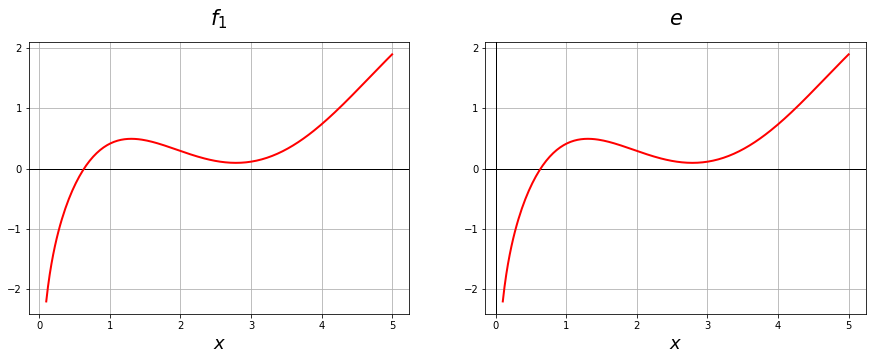

In [2]:
# specify range of input for our functions
x = np.linspace(0.1,5,200)
x.shape = (len(x),1)

# create function using full equation
f1 = np.tanh(x)*np.cos(x) + np.log(x)

# generate plot using parent-child equations
a = np.tanh(x)
b = np.cos(x)
c = np.log(x)
d = a*b
e = d + c

# reshape each form and stack into table
f1.shape = (len(f1),1)
table1 = np.stack((x,f1), axis=1) 
e.shape = (len(e),1)
table2 = np.stack((x,e),axis=1)

# use custom plotter to show both functions
baslib.basics_plotter.double_plot(table1 = table1, table2 = table2,plot_type = 'continuous',xlabel = '$x$',ylabel_1 = '$f_1$',ylabel_2 = '$e$',fontsize = 18)

#### <span style="color:#a50e3e;">Example. </span> Deriving a function's equation from its computation graph 

Given the following computation graph 

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_func_0.png?raw=1" width="80%" height="auto"></p>

we can easily complete the equation it represents by navigating the graph forward, starting from the input node $x_1$.  

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_func_1.png?raw=1" width="80%" height="auto"></p>

---

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_func_2.png?raw=1" width="80%" height="auto"></p>

---

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_func_3.png?raw=1" width="80%" height="auto"></p>

---

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/reverse_func_4.png?raw=1" width="80%" height="auto"></p>

In other words, our equation is

$$
f(x) = \text{cos}(x_1^2 + x_2^2)
$$

which we plot in the next Python cell.  Note that the default viewing angle here has been set to a bird's eye view - looking down on the function directly from above.

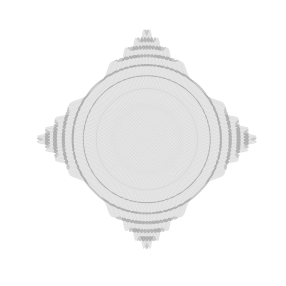

In [3]:
# what function should we play with?  Defined in the next line.
f = lambda x: np.cos( x[0]**2 + x[1]**2)

# create an instance of the visualizer with this function
opt_test = baslib.math_function_plotting_3d.visualizer()

# run
view = [-90,45]
input_range = np.linspace(-5,5,1000) 
opt_test.draw_it(g = f,set_figsize = 5,set_axis = 'off',view = view,input_range=input_range)  # other options: horiz_1_label = 'horizontal_1',horiz_2_label = 'horizontal_2',vert_label = 'vertical',set_title = 'my title')

#### <span style="color:#a50e3e;">Example. </span>  Constructing a new function out of elementary parts 

What can we build using a short list of elementary parts - including addition / subtraction / multiplication / division, and a few elementary functions?  We have a great number of choices with how to start, but lets begin by defining two child nodes and go from there.

We start with multiplication by a constant 

$$
a(x) = 20\times x
$$

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/construct_a.png?raw=1" width="80%" height="auto"></p>

and another child node that creating that squares the input as

$$
b(x) = x^2
$$

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/construct_b.png?raw=1" width="80%" height="auto"></p>

Now we have two child nodes, both transformations of the input $x$.  Next, lets shove $a$ through a cosine function, and add 1 to $b$ giving two parent nodes

$$
c(a) = \text{cos}(a)\\
d(b) = b + 1 \\
$$

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/construct_c_d.png?raw=1" width="80%" height="auto"></p>

Finally lets make a division parent for $d$, and multiply the result by $c$ as 

$$
e(d) = \frac{1}{d} \\
f(c,e) = c\times e \\
$$

<p><img src="https://github.com/jermwatt/computational_maths/blob/collab/compmaths_images/construct_e_f.png?raw=1" width="80%" height="auto"></p>

giving the final parent node $f$.  All together then, we have made a set of parent-child equations (note here we will leave off the parentheses on the left side denoting input for readability purposes since the associated input of each equation is clear from the right hand side of each equation)

\begin{array}
\
a = 20 \times x \\
b = x^2 \\
c = \text{cos}(a)\\
d = b + 1 \\
e = \frac{1}{d} \\
f = c\times e \\
\end{array}

Of course this is an inferior way of detailing these parent-child relationships, which are better expressed by visualizing the graph as shown above.

We plot the full function

$$
g(x) = \frac{\text{cos}(20x)}{x^2 + 1}
$$

in the next Python cell.

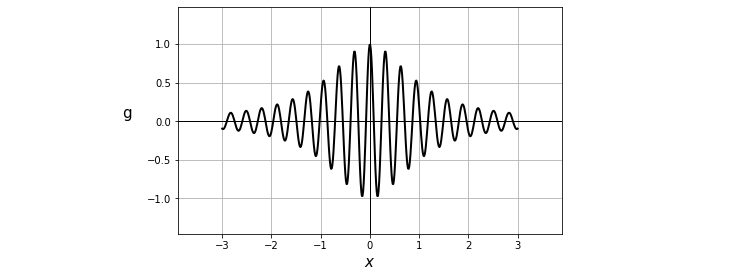

In [4]:
# specify range of input for our function
x = np.linspace(-3,3,500)

# form the equation
g = np.cos(20*x)/(x**2 + 1)

# make a table of values for our function
table1 = np.stack((x,g), axis=1)  

# use custom plotter to display function
baslib.basics_plotter.single_plot(table = table1,xlabel = '$x$',ylabel = 'g',rotate_ylabel = 0)

## 2.2 Section summary

As with arithmetic expressions, we have now seen how to construct / deconstruct complex equations into their elementary parts using the computation graph.  This shows how complex equations can be constructed from sequentially composed parent-child equations, where each equation consists of either one or two inputs and an operation of function transformation.  Moreover we saw how in particular how any function can be represented as a nested composition of the parent-child equations defined by its computation graph.